# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)



import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import scipy.linalg as linalg

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator

import pyaldata as pyal

%matplotlib inline

try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    defs = params.monkey_defs
    monkey_defs = defs
    
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root
    reload(defs)
    reload(dt)
    reload(params) 

finally:
    os.chdir(nbPath)

if "__file__" not in dir():
    %run "_dataset-selection.ipynb"

In [2]:
def get_full_monkey_data():
    full_list_MCx = []
    for animal, sessionList in GoodDataList[monkey_defs.areas[2]].items():
        if 'Mr' in animal:
            continue  # to remove MrT
        full_list_MCx.append((animal,sessionList))
    full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
    # load the DFs
    allDFs_MCx = []
    for animal, session in full_list_MCx:
        path = root/animal/session
        allDFs_MCx.append(monkey_defs.prep_general(dt.load_pyal_data(path)))

    return full_list_MCx, allDFs_MCx

collecting all the data in a matrix, `AllData`: $sessions \times targets \times  trials \times time \times PCs$

In [3]:
if "__file__" not in dir():
    warnings.filterwarnings("ignore")
    full_list_MCx, allDFs_MCx = get_full_monkey_data()
    
    pairFileList1 = []
    for I, (animal1,session1) in enumerate(full_list_MCx):
        for J, (animal2,session2) in enumerate(full_list_MCx):
            if J<=I or animal1 == animal2: continue  # to repetitions
            if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
            pairFileList1.append((I,J))

    side1df = [allDFs_MCx[i] for i,_ in pairFileList1]
    side2df = [allDFs_MCx[j] for _,j in pairFileList1]

    AllData1 = dt.get_data_array(side1df, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    AllData2 = dt.get_data_array(side2df, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)

    warnings.filterwarnings("default")

do the CCA calculation on shifted targets

In [4]:
if "__file__" not in dir():
    CCs = []
    for shift in range(defs.n_targets-1):
        for sessionData1,sessionData2 in zip(AllData1,AllData2):
            sessionData2_ = np.roll(sessionData2, shift=shift+1 ,axis=0)

            data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData2_[:,:min_trials,:min_time,:], (-1,defs.n_components))
            CCs.append(dt.canoncorr(data1, data2))
    CCs = np.array(CCs)

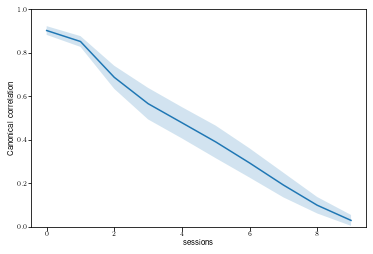

In [8]:
if "__file__" not in dir():
    utility.shaded_errorbar(plt.gca(),CCs.T,)
    plt.ylim([0,1])
    plt.xlabel('sessions')
    plt.ylabel('Canonical correlation')
    plt.savefig(params.figPath / 'cca-shifted-target.pdf', format='pdf', bbox_inches='tight')

CCA on shuffled targets

In [9]:
if "__file__" not in dir():
    CCs = []
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        sessionData1_sh = params.rng.permutation(sessionData1,axis=0)
        sessionData2_sh = params.rng.permutation(sessionData2,axis=0)

        data1 = np.reshape(sessionData1_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
        CCs.append(dt.canoncorr(data1, data2))
    CCs = np.array(CCs)

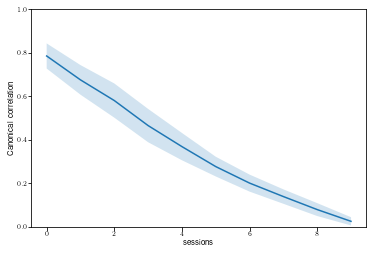

In [10]:
if "__file__" not in dir():
    utility.shaded_errorbar(plt.gca(),CCs.T,)
    plt.ylim([0,1])
    plt.xlabel('sessions')
    plt.ylabel('Canonical correlation')
    plt.savefig(params.figPath / 'cca-shuffled-target.pdf', format='pdf', bbox_inches='tight')

# Decode

In [12]:
def prep_example_df():
    raster_example = defs.raster_example
    raster_example_df = []
    for session in raster_example:
        path = root/session.split('_')[0]/session
        df = defs.prep_general(dt.load_pyal_data(path))
        # df = pyal.restrict_to_interval(df, epoch_fun=monkey_defs.exec_epoch)
        raster_example_df.append(df)
    return raster_example_df
exDFs = prep_example_df()


/home/msafaie/REPOS/multi-animal-alignment/packages/pyaldata/pyaldata/firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/multi-animal-alignment/packages/pyaldata/pyaldata/firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


In [14]:
def plot_monkey_decoding_shuffled(ax, allDFs):
    defs = params.monkey_defs

    within_score = {}
    aligned_score = {}
    unaligned_score = {}
    for i, df1 in enumerate(tqdm(allDFs)):
        AllData, AllVel = defs.get_data_array_and_vel([df1], defs.exec_epoch_decode,
                                                    area=defs.areas[2], n_components=defs.n_components)
        # adding history
        AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)
        AllData = AllData[...,defs.MAX_HISTORY:,:]
        AllVel = AllVel[...,defs.MAX_HISTORY:,:]
        AllData1 = AllData[0,...]
        AllVel1 = AllVel[0,...]
        *_,n_time,n_comp = AllData1.shape
        # resizing
        X1 = AllData1.reshape((-1,n_time,n_comp))
        AllVel1 = AllVel1.reshape((-1,n_time,2))
        
        fold_score =[]
        kf = KFold(n_splits=10)
        for train_index, test_index in kf.split(X1[:,0,0]):
            x_train, x_test = X1[train_index,...], X1[test_index,...]
            y_train, y_test = AllVel1[train_index,...], AllVel1[test_index,...]

            lstm_model = lstm.LSTMDecoder(input_dims=X1.shape[-1], output_dims=2)
            lstm_model.fit(x_train=x_train, y_train=y_train)
            lstm_model.predict(x_test, y_test)
            fold_score.append(lstm_model.score)
        fold_score = np.median(fold_score)
        within_score[df1.session[0]] = fold_score

        aligned_score[df1.session[0]] = {}
        unaligned_score[df1.session[0]] = {}
        for j, df2 in enumerate(tqdm(allDFs)):
            if j <= i: continue
            if df1.monkey[0] == df2.monkey[0]: continue
            if 'Chewie' in df1.monkey[0] and 'Chewie' in df2.monkey[0]: continue

            AllData, AllVel = defs.get_data_array_and_vel([df1,df2],
                                                        defs.exec_epoch_decode, area=defs.areas[2], n_components=defs.n_components)
            # adding history
            AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)
            AllData = AllData[...,defs.MAX_HISTORY:,:]
            AllVel = AllVel[...,defs.MAX_HISTORY:,:]

            AllData1 = AllData[0,...]
            AllData2 = AllData[1,...]
            AllVel1 = AllVel[0,...]
            AllVel2 = AllVel[1,...]
            # resizing
            *_,n_time,n_comp = AllData1.shape

            X1 = AllData1.reshape((-1,n_comp))
            X2 = AllData2.reshape((-1,n_comp))
            AllVel2 = AllVel2.reshape((-1,n_time,2))
            AllVel1 = AllVel1.reshape((-1,n_time,2))

            # train the aligned
            *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
            U = U.reshape((-1,n_time,n_comp))
            V = V.reshape((-1,n_time,n_comp))
            X1 = X1.reshape((-1,n_time,n_comp))
            X2 = X2.reshape((-1,n_time,n_comp))

            lstm_model = lstm.LSTMDecoder(input_dims=U.shape[-1], output_dims=2)
            lstm_model.fit(x_train=U, y_train=AllVel1)
            lstm_model.predict(V, AllVel2)
            aligned_score[df1.session[0]][df2.session[0]]=lstm_model.score.mean()

            #================================
            # Unaligned
            lstm_model = lstm.LSTMDecoder(input_dims=U.shape[-1], output_dims=2)
            lstm_model.fit(x_train=X1, y_train=AllVel1)
            lstm_model.predict(X2, AllVel2)
            unaligned_score[df1.session[0]][df2.session[0]]=lstm_model.score.mean()

    #======================== PLOTTING
    pop_within = np.array(list(within_score.values()))
    pop_aligned = np.array([val for key in aligned_score for val in aligned_score[key].values()])
    pop_unaligned = np.array([val for key in unaligned_score for val in unaligned_score[key].values()])

    ax.errorbar(1, pop_aligned.mean(), np.std(pop_aligned), label='Across\n' r'(\textit{aligned})',
                color=params.colors.MainCC, fmt='-o', capsize=1.5)    
    ax.errorbar(0, pop_unaligned.mean(), np.std(pop_unaligned), label='Across\n' r'(\textit{unaligned})',
                color=params.colors.LowerCC, fmt='-o', capsize=1.5)
    ax.errorbar(2, pop_within.mean(), np.std(pop_within), label='Within',
                color=params.colors.UpperCC, fmt='-o', capsize=1.5)

    for file1, nested_dict in aligned_score.items():
        wi_val1 = within_score[file1]
        for file2, al_val in nested_dict.items():
            wi_val2 = within_score[file2]
            unal_val = unaligned_score[file1][file2]
            ax.plot([0,1,2], [unal_val, al_val, wi_val1],
                    color='gray', lw=.2, zorder=6, marker = 'o', ms=.1, alpha=.2)
            ax.plot([1,2], [al_val, wi_val2],
                    color='gray', lw=.2, zorder=6, marker = 'o', ms=.1, alpha=.2)

    
    ax.set_xlim([-0.2,2.2])
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(['Across\n' r'(\textit{unaligned})',
                        'Across\n' r'(\textit{aligned})',
                        'Within'])
    ax.set_ylabel('Prediction accuracy ($R^2$)')
    ax.set_ylim([-.05,1])
    # ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([0,2])
    ax.spines['left'].set_bounds([0,1])



In [ ]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()

    fig, axes = plt.subplots(1,2)  
    plot_monkey_decoding(axes[0], exDFs)
    plot_monkey_decoding(axes[1], exDFs)
    fig.savefig('decoding-vaf.pdf')
    plt.show()